**Install packages**

In [ ]:
!git clone https://github.com/maudl3116/CondSigKME.git

In [ ]:
%cd CondSigKME

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install git+https://github.com/maudl3116/sigkernel.git

**Generate one dataset**

In [ ]:
%cd n_vcn_utils

In [ ]:
!sh dataset.sh

**Run one toy experiment**

In [ ]:
%cd ../

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from n_vcn_utils.utils import load_data
from src.SigKPC.pcskeleton import skeleton

get the ground truth graph

In [ ]:
nball = 5

# load information about the dataset
data_names = ['attrs', 'states', 'actions', 'rels']
stat_path = os.path.join('n_vcn_utils/data/data_Ball/valid/', '0.h5')
metadata = load_data(data_names, stat_path)
edge_type = metadata[data_names.index('rels')][0, :, 0].astype(np.int)

# get the ground truth graph
ground_truth = np.zeros((nball,nball))
cnt = 0
for i in range(nball):
    for j in range(i):
        ground_truth[i,j] = edge_type[cnt]
        ground_truth[j,i] = edge_type[cnt]
        cnt+=1
# np.argwhere(ground_truth==1)

In [4]:
n_repeat = 50  # number of times the n bodies are simulated 
dataset = []
for i in range(n_repeat):
    stat_path = os.path.join('n_vcn_utils/data/data_Ball/valid/', '{}.h5'.format(i))
    metadata = load_data(data_names, stat_path)
    data = metadata[data_names.index('states')][:20,:,:2]  # (time,nball,4)
    data = data.transpose(1,0,2) # (nball, time, dim)
    dataset.append(data[:,None,:,:]) # (nball, M, time, dim)

In [5]:
data_= np.concatenate(dataset, axis=1)

In [ ]:
graph = skeleton(data_*0.01, alpha=0.5, test= False, p=nball, maxi=1, fixedGaps=None, eps=0.01, dyadic_order=2, static='rbf', sigma=10.)

In [ ]:
pval = graph[2].copy()
print('matrix of hsic scores \n',pval)
# print(graph[0])
print('\n ground truth graph \n',ground_truth)

In [9]:
alpha = 0.6  # the lower the alpha, the more edges 

edge = np.zeros(nball*(nball-1)//2)
cnt = 0
for i in range(nball):
    for j in range(i):
        if pval[i,j]<alpha:
            edge[cnt]=0
        else:
            edge[cnt]=1
        cnt+=1
print('us',edge.astype(int))
print('gt',edge_type)
print('correct fraction', np.mean(edge.astype(int)==edge_type))

us [1 1 1 1 0 0 1 1 1 0]
gt [1 1 1 1 0 0 1 1 1 0]
correct fraction 1.0


**Plot n-bodies**

In [24]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, Circle, Polygon

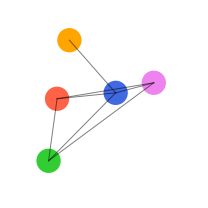

In [31]:
metadata = load_data(data_names, stat_path)
data = metadata[data_names.index('states')]   # (time,nball,4)

time_step = 4

c = ['royalblue', 'tomato', 'limegreen', 'orange', 'violet', 'chocolate', 'black', 'crimson']
fig, ax = plt.subplots(1)
lim=(-80, 80, -80, 80)
plt.xlim(lim[0], lim[1])
plt.ylim(lim[2], lim[3])
plt.axis('off')

fig.set_size_inches(3, 3)

cnt = 0
for x in range(nball):
    for y in range(x):
        rel_type = int(edge_type[cnt]); cnt += 1
        if rel_type == 0:
            continue

        plt.plot([data[time_step, x, 0], data[time_step, y, 0]],
                  [data[time_step, x, 1], data[time_step, y, 1]],
                  '-', color='k', lw=1, alpha=0.5)

circles = []
circles_color = []
for j in range(nball):
    circle = Circle((data[time_step, j, 0], data[time_step, j, 1]), radius=10)
    circles.append(circle)
    circles_color.append(c[j % len(c)])


pc = PatchCollection(circles, facecolor=circles_color, linewidth=1)
ax.add_collection(pc)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
plt.tight_layout()
plt.show()